# Fixing the bands to jpeg model:

In [3]:
# Imports
import data_utils
import rasterio

import geopandas as gpd
import rasterio
import numpy as np
from rasterio.windows import Window
from rasterio import merge
from rasterio.errors import RasterioIOError
from shapely.geometry import box
import cv2
import os
import matplotlib.pyplot as plt

In [9]:
src1 = rasterio.open('B1.TIF')
src2 = rasterio.open('B2.TIF')
src3 = rasterio.open('B3.TIF')

In [10]:
# Open the first band.
with rasterio.open('B1.TIF') as src:
    # Read metadata from the first band.
    meta = src.meta

    # Update metadata to reflect the number of layers.
    meta.update(count = 3)

    # Read each layer and write it to stack.
    with rasterio.open('3band.TIF', 'w', **meta) as dst:
        
        with rasterio.open('B1.TIF') as src1:
            dst.write_band(1,src1.read(1))

        with rasterio.open('B2.TIF') as src1:
            dst.write_band(2,src2.read(1))

        with rasterio.open('B3.TIF') as src1:
            dst.write_band(3,src3.read(1))


In [165]:
band3 = rasterio.open('3band.TIF')
patch = band3.read()
print(patch.shape[0])
print(patch)

print(patch[0].min())
print(patch[1].min())
print(patch[2].min())
print(patch[0].max())
print(patch[1].max())
print(patch[2].max())
print(patch.mean(axis=(1,2)))

3
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
0
0
0
65535
50556
65535
[5722.58239835 6095.00808006 5919.50305773]


In [169]:
band3 = rasterio.open('3band.TIF')
patch = band3.read()

def save_raster_patch_as_jpg(patch, output_filename, min_percent=0, gamma=3.5, max_percent=75,num_std_dev=2):

    # If there are more than 3 bands, keep only the first 3 bands
    if patch.shape[0] > 3:
        patch = patch[:3, :, :]    

    # Convert data range to [0, 255] for JPG images.
    if patch.dtype == np.uint16:
        scale_factor = 65535 // 255
        patch = (patch / scale_factor).astype(np.uint8)
    elif patch.max() <= 1:  # float images in [0, 1] range
        patch = (patch * 255).astype(np.uint8)
    
    # Compute mean and standard deviation for each band
    mean_val = np.mean(patch, axis=(1,2))
    std_val = np.std(patch, axis=(1,2))

    # Compute lower and upper bounds for the stretch
    lower_val = mean_val - num_std_dev * std_val
    upper_val = mean_val + num_std_dev * std_val

    # Stretch and rescale to [0, 255] for each band
    for i in range(patch.shape[0]):
        #patch[i, :, :] = np.clip(patch[i, :, :], lower_val[i], upper_val[i])
        patch[i, :, :] = np.clip(patch[i, :, :], lower_val[i], upper_val[i])
        patch[i, :, :] = (255 * (patch[i, :, :] - lower_val[i])) / (upper_val[i] - lower_val[i])
        patch[i, :, :] = np.clip(patch[i, :, :], 0, 255).astype(np.uint8)
        
    # Gamma correction:
    # Normalize to [0,1]
    normalized_patch = patch / 255.0

    # Apply gamma correction
    gamma_corrected_patch = np.power(normalized_patch, gamma)

    # If you want to scale back to [0, 255]
    gamma_corrected_patch_255 = (gamma_corrected_patch * 255).astype(np.uint8)
    
    # Save the patch as a new JPG file.
    with rasterio.open(output_filename, 'w', driver='JPEG', height=patch.shape[1], width=patch.shape[2], count=patch.shape[0], dtype=patch.dtype) as dest:
        dest.write(gamma_corrected_patch_255)
        
save_raster_patch_as_jpg(patch,'gamma_clip.jpeg')

1st test
0
0
0
65535
50556
65535
2nd test
0
0
0
255
196
255
[-13.11409063 -13.06574327 -13.2785536 ]
[56.98326088 59.82873359 58.67610633]


In [101]:

def save_raster_patch_as_jpg(patch, output_filename):

    # If there are more than 3 bands, keep only the first 3 bands
    if patch.shape[0] > 3:
        patch = patch[:3, :, :]

    # Use RGB channel order for JPG images.
    #patch = patch[[2,0,1],:,:]

    # Convert data range to [0, 255] for JPG images.
    if patch.dtype == np.uint16:
        scale_factor = 65535 // 255
        patch = (patch / scale_factor).astype(np.uint8)
    elif patch.max() <= 1:  # float images in [0, 1] range
        patch = (patch * 255).astype(np.uint8)

    # Save the patch as a new JPG file.
    with rasterio.open(output_filename, 'w', driver='JPEG',height=patch.shape[1], width=patch.shape[2], count=patch.shape[0], dtype=patch.dtype) as dest:
        dest.write(patch)

In [117]:
import numpy as np
import rasterio

def save_raster_patch_as_jpg(patch, output_filename, min_percent=25, max_percent=80):

    # If there are more than 3 bands, keep only the first 3 bands
    if patch.shape[0] > 3:
        patch = patch[:3, :, :]

    # Compute percent clip values for each band
    lower_val = np.percentile(patch, min_percent, axis=(1,2))
    upper_val = np.percentile(patch, max_percent, axis=(1,2))
    
    print(lower_val)
    print(upper_val)
    
    #Copying patch to temp
    temp = patch

    # Apply percent clip and rescale to [0, 255] for each band
    for i in range(patch.shape[0]):
        patch[i, :, :] = np.clip(patch[i, :, :], lower_val[i], upper_val[i])
        #if patch.dtype == np.uint16:
        #    temp[i, :, :] = ((patch[i, :, :] - lower_val[i]) * 255 / (upper_val[i] - lower_val[i])).astype(np.uint8)

    # Convert data range to [0, 255] for JPG images.
    if patch.dtype == np.uint16:
        scale_factor = 65535 // 255
        patch = (patch / scale_factor).astype(np.uint8)
    elif patch.max() <= 1:  # float images in [0, 1] range
        patch = (patch * 255).astype(np.uint8)

    # Save the patch as a new JPG file.
    with rasterio.open(output_filename, 'w', driver='JPEG',height=patch.shape[1], width=patch.shape[2], count=patch.shape[0], dtype=patch.dtype) as dest:
        dest.write(patch)




In [128]:
save_raster_patch_as_jpg(patch,'clip.jpeg')

[0. 0. 0.]
[8126. 8797. 8404.]


In [109]:
print(patch[0].max())
print(patch[1].max())
print(patch[2].max())

8064
8689
8280


In [83]:
plt.imshow(src1.read(1), cmap='gray')

RasterioIOError: Dataset is closed: B3.TIF

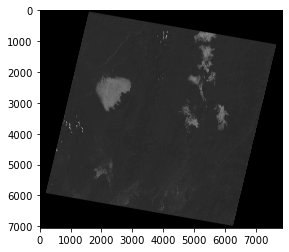

In [69]:
plt.imshow(src2.read(1), cmap='gray')

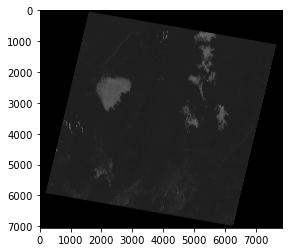

In [70]:
plt.imshow(src3.read(1), cmap='gray')

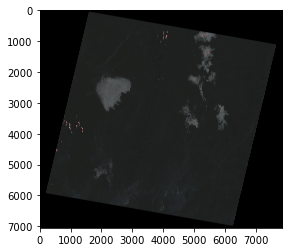

In [75]:
transposed_data = patch.transpose(1, 2, 0)
scaled_data = (transposed_data / 256).astype('uint8')
plt.imshow(scaled_data)

In [90]:
min_percent = 25
max_percent = 75

lower_val = np.percentile(patch, min_percent, axis=(1,2))
upper_val = np.percentile(patch, max_percent, axis=(1,2))

In [91]:
print(lower_val)
print(upper_val)

[0. 0. 0.]
[8064. 8689. 8280.]
